# Final Capstone

In this project we will put ourselves in the shoes of an NFL defensive coordinator, specifically in the shoes of the defensive coordinator for the Houston Texans. We're playing the New England Patriots in the 2018 NFL playoffs and we need to stop Tom Brady, Bill Belichick and the Patriots' offense. Instead of using 'gut feel' to guess what play the Patriots will run next (and what we need to be prepared for), we will use machine learning techniques to help us determine the most likely play type in any game situation. We'll begin by importing our data set, which is hosted on Kaggle and contains information about every play run in the NFL from 2009 through 2018. 

In [1]:
# importing packages we'll need
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
%matplotlib inline
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')

In [2]:
# reading the data set
df = pd.read_csv('NFL_data.csv', low_memory=False)
# https://www.kaggle.com/maxhorowitz/nflplaybyplay2009to2016/download

In [3]:
# reading the data set
defenses_df = pd.read_csv('defensive_data.csv', low_memory=False)
# http://www.nfl.com/stats/categorystats?seasonType=REG&offensiveStatisticCategory=null&d-447263-n=1&d-447263-o=1&d-447263-p=1&d-447263-s=RUSHING_YARDS_PER_GAME_AVG&tabSeq=2&season=2018&role=OPP&Submit=Go&archive=true&conference=null&defensiveStatisticCategory=RUSHING&qualified=false

In [4]:
df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [5]:
NE_df = df.loc[df['posteam'] == 'NE', ]

New England has had the same head coach, offensive coordinator, and quarterback since the 2012 season, so we will remove the data before that season.

In [6]:
NE_df['game_date'] = pd.to_datetime(NE_df['game_date'])

In [7]:
NE_df = NE_df.loc[NE_df['game_date'] > datetime.datetime(2012, 7, 1), ]

In [8]:
NE_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
135504,360,2012090904,TEN,NE,NE,away,TEN,TEN,35.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135505,387,2012090904,TEN,NE,NE,away,TEN,NE,74.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135506,411,2012090904,TEN,NE,NE,away,TEN,NE,66.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135507,432,2012090904,TEN,NE,NE,away,TEN,NE,65.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135508,453,2012090904,TEN,NE,NE,away,TEN,TEN,48.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


## Data Exploration

Now that we've got the data filtered down to plays run by our opponent under the current offensive staff, let's begin exploring the data.

In [9]:
list(NE_df)

['play_id',
 'game_id',
 'home_team',
 'away_team',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'no_sc

In [10]:
NE_df.play_type.unique()

array(['kickoff', 'pass', 'run', 'punt', 'extra_point', 'no_play',
       'qb_kneel', 'field_goal', 'qb_spike'], dtype=object)

In [11]:
play_list = ['pass', 'run']

In [12]:
NE_df = NE_df.loc[NE_df.play_type.isin(play_list), ]

In [13]:
NE_df.head(35)

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
135505,387,2012090904,TEN,NE,NE,away,TEN,NE,74.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135506,411,2012090904,TEN,NE,NE,away,TEN,NE,66.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135507,432,2012090904,TEN,NE,NE,away,TEN,NE,65.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135508,453,2012090904,TEN,NE,NE,away,TEN,TEN,48.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135509,475,2012090904,TEN,NE,NE,away,TEN,TEN,48.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135510,496,2012090904,TEN,NE,NE,away,TEN,TEN,46.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135516,634,2012090904,TEN,NE,NE,away,TEN,NE,67.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135517,655,2012090904,TEN,NE,NE,away,TEN,NE,67.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135518,679,2012090904,TEN,NE,NE,away,TEN,TEN,39.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
135519,705,2012090904,TEN,NE,NE,away,TEN,TEN,22.0,2012-09-09,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [14]:
NE_df.play_type.unique()

array(['pass', 'run'], dtype=object)

In [15]:
def get_full_play_type(play):
    play_type, pass_location, run_location, pass_length = play
    if(play_type == 'run'):
        return play_type+'_'+ run_location
    else:
        return pass_length +'_'+play_type+'_'+ pass_location
NE_df = NE_df.replace(np.nan, 'unknown', regex=True)  


NE_df['full_play_type'] = NE_df[['play_type','pass_location', 'run_location', 'pass_length']].apply(get_full_play_type, axis=1)


In [16]:
NE_df.head()

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv,full_play_type
135505,387,2012090904,TEN,NE,NE,away,TEN,NE,74.0,2012-09-09,...,unknown,unknown,0,unknown,unknown,0.0,0.0,0.0,0.0,short_pass_right
135506,411,2012090904,TEN,NE,NE,away,TEN,NE,66.0,2012-09-09,...,unknown,unknown,0,unknown,unknown,0.0,0.0,0.0,0.0,run_left
135507,432,2012090904,TEN,NE,NE,away,TEN,NE,65.0,2012-09-09,...,unknown,unknown,0,unknown,unknown,0.0,0.0,0.0,0.0,run_left
135508,453,2012090904,TEN,NE,NE,away,TEN,TEN,48.0,2012-09-09,...,unknown,unknown,0,unknown,unknown,0.0,0.0,0.0,0.0,deep_pass_left
135509,475,2012090904,TEN,NE,NE,away,TEN,TEN,48.0,2012-09-09,...,unknown,unknown,0,unknown,unknown,0.0,0.0,0.0,0.0,run_middle


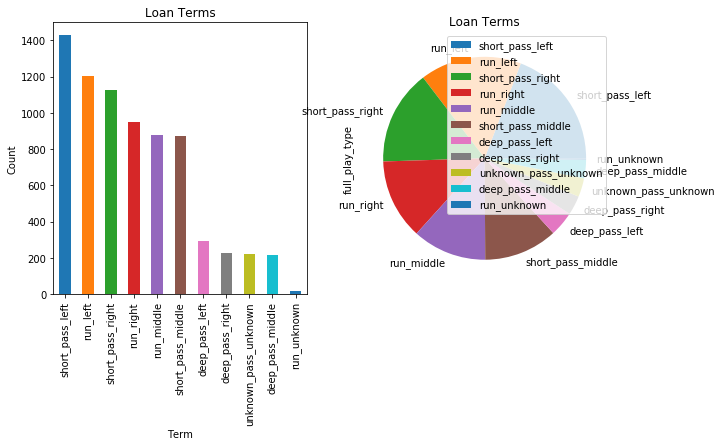

In [17]:
plt.figure(figsize=(10, 5)) #making a subplot

plt.subplot(1, 2, 1)
NE_df.full_play_type.value_counts().plot(kind='bar')
plt.title('Loan Terms')
plt.ylabel('Count')
plt.xlabel('Term')

plt.subplot(1, 2, 2)
NE_df.full_play_type.value_counts().plot(kind='pie')
plt.title('Loan Terms')
plt.legend()
plt.show()

In [18]:
NE_df.down.unique()

array([1.0, 2.0, 3.0, 'unknown', 4.0], dtype=object)

In [19]:
first_df = NE_df.loc[NE_df['down'] == 1.0, ]
second_df = NE_df.loc[NE_df['down'] == 2.0, ]
third_df = NE_df.loc[NE_df['down'] == 3.0, ]

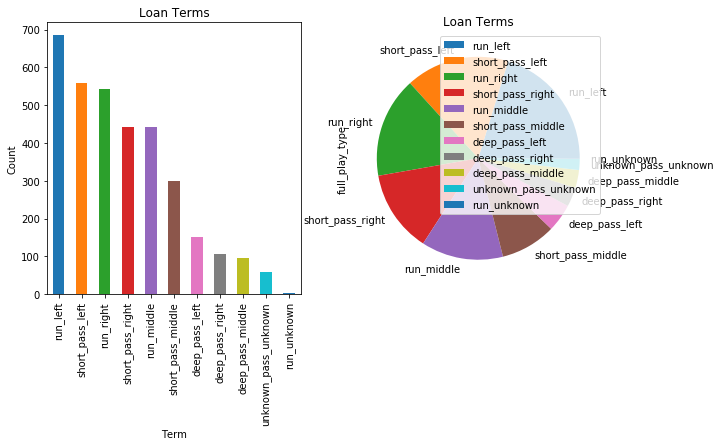

In [20]:
plt.figure(figsize=(10, 5)) #making a subplot

plt.subplot(1, 2, 1)
first_df.full_play_type.value_counts().plot(kind='bar')
plt.title('Loan Terms')
plt.ylabel('Count')
plt.xlabel('Term')

plt.subplot(1, 2, 2)
first_df.full_play_type.value_counts().plot(kind='pie')
plt.title('Loan Terms')
plt.legend()
plt.show()

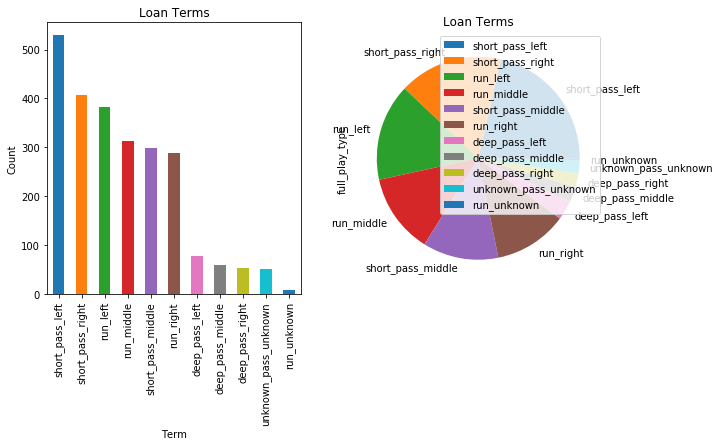

In [21]:
plt.figure(figsize=(10, 5)) #making a subplot

plt.subplot(1, 2, 1)
second_df.full_play_type.value_counts().plot(kind='bar')
plt.title('Loan Terms')
plt.ylabel('Count')
plt.xlabel('Term')

plt.subplot(1, 2, 2)
second_df.full_play_type.value_counts().plot(kind='pie')
plt.title('Loan Terms')
plt.legend()
plt.show()

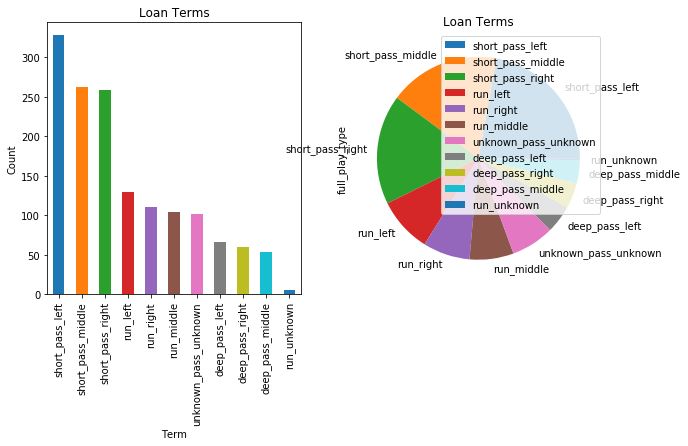

In [22]:
plt.figure(figsize=(10, 5)) #making a subplot

plt.subplot(1, 2, 1)
third_df.full_play_type.value_counts().plot(kind='bar')
plt.title('Loan Terms')
plt.ylabel('Count')
plt.xlabel('Term')

plt.subplot(1, 2, 2)
third_df.full_play_type.value_counts().plot(kind='pie')
plt.title('Loan Terms')
plt.legend()
plt.show()

In [23]:
pass_df = NE_df.loc[NE_df['play_type'] == 'pass', ]
run_df = NE_df.loc[NE_df['play_type'] == 'run', ]

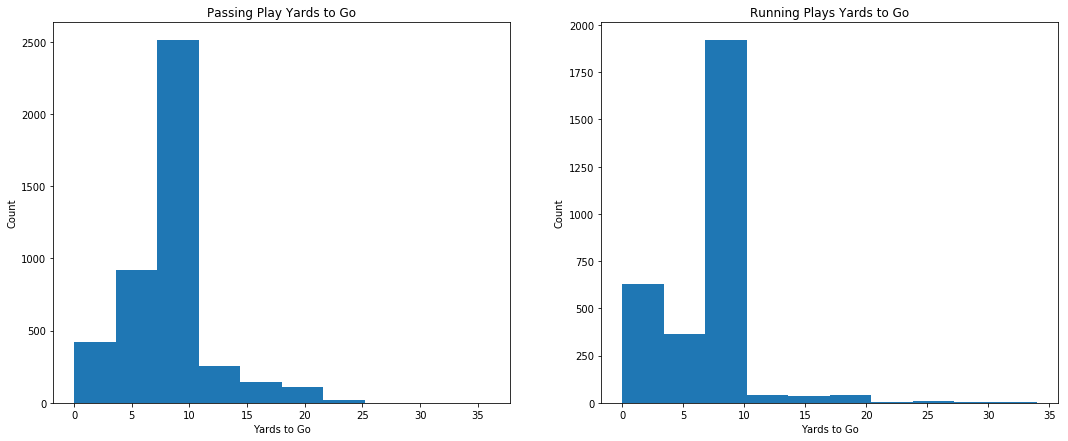

In [24]:
plt.figure(figsize=(18, 7))

plt.subplot(1, 2, 1)
plt.hist(pass_df.ydstogo)
plt.title('Passing Play Yards to Go')
plt.ylabel('Count')
plt.xlabel('Yards to Go')

plt.subplot(1, 2, 2)
plt.hist(run_df.ydstogo)
plt.title('Running Plays Yards to Go')
plt.ylabel('Count')
plt.xlabel('Yards to Go')
plt.show()

Text(0.5, 0, 'Full Play Type')

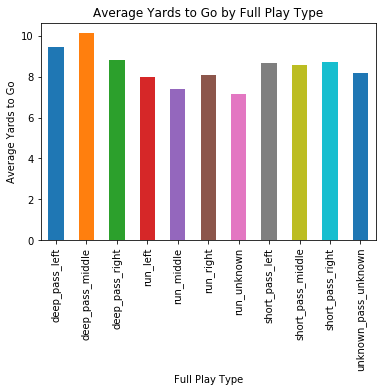

In [25]:

full_plays = NE_df.groupby('full_play_type') # grouping the data by full play type
full_plays.ydstogo.mean().plot(kind='bar')
plt.title('Average Yards to Go by Full Play Type')
plt.ylabel('Average Yards to Go')
plt.xlabel('Full Play Type')

## K-Means Clustering- Unnormalized Data

In [26]:
defenses_df.head()

,Pass_Rk,Team,Pts/G,TotPts,TotYards,Comp,Att,Comp_Pct,Att/G,Pass_Yds,...,Run_Att/G,Rush_Yds,Rush_Avg,Rush_Yds/G,Rush_TD,Run_Lng,Run_1st%,Run_20+,Run_40+,FUM
0,4,Arizona Cardinals,26.6,425,5741.0,342,506,67.6,31.6,3262,...,31.9,2479,4.9,154.9,25,65,27.3,21,4,3
1,27,Atlanta Falcons,26.4,423,6152.0,398,585,68.0,36.6,4153,...,25.6,1999,4.9,124.9,16,92,28.1,13,1,10
2,5,Baltimore Ravens,17.9,287,4687.0,337,577,58.4,36.1,3360,...,22.1,1327,3.7,82.9,11,35,23.2,6,0,2
3,1,Buffalo Bills,23.4,374,4706.0,313,492,63.6,30.8,2867,...,27.5,1839,4.2,114.9,17,43,25.2,12,1,10
4,18,Carolina Panthers,23.9,382,5651.0,353,529,66.7,33.1,3847,...,24.0,1804,4.7,112.8,13,60,28.6,17,2,9


In [27]:
team_list = list(defenses_df['Team'])
defenses_df = defenses_df.drop('Team', 1)

In [28]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=4, random_state=42).fit(defenses_df)

km_labels = km.labels_

km_cluster_centers = km.cluster_centers_

In [29]:
defenses_df['cluster'] = km_labels
defenses_df['Team'] = team_list

In [30]:
defenses_df.head(32)

,Pass_Rk,Pts/G,TotPts,TotYards,Comp,Att,Comp_Pct,Att/G,Pass_Yds,Pass_Avg,...,Rush_Avg,Rush_Yds/G,Rush_TD,Run_Lng,Run_1st%,Run_20+,Run_40+,FUM,cluster,Team
0,4,26.6,425,5741.0,342,506,67.6,31.6,3262,7.1,...,4.9,154.9,25,65,27.3,21,4,3,2,Arizona Cardinals
1,27,26.4,423,6152.0,398,585,68.0,36.6,4153,7.5,...,4.9,124.9,16,92,28.1,13,1,10,3,Atlanta Falcons
2,5,17.9,287,4687.0,337,577,58.4,36.1,3360,6.3,...,3.7,82.9,11,35,23.2,6,0,2,0,Baltimore Ravens
3,1,23.4,374,4706.0,313,492,63.6,30.8,2867,6.3,...,4.2,114.9,17,43,25.2,12,1,10,0,Buffalo Bills
4,18,23.9,382,5651.0,353,529,66.7,33.1,3847,7.7,...,4.7,112.8,13,60,28.6,17,2,9,2,Carolina Panthers
5,7,17.7,283,4795.0,377,615,61.3,38.4,3515,6.3,...,3.8,80.0,5,32,19.8,7,0,5,0,Chicago Bears
6,32,28.4,455,6618.0,389,584,66.6,36.5,4414,7.9,...,4.7,137.8,17,65,26.8,15,2,3,3,Cincinnati Bengals
7,25,24.5,392,6288.0,393,626,62.8,39.1,4125,7.0,...,4.7,135.2,20,52,28.3,18,1,6,3,Cleveland Browns
8,13,20.2,324,5268.0,367,542,67.7,33.9,3755,7.4,...,3.8,94.6,12,68,22.3,9,1,7,2,Dallas Cowboys
9,20,21.8,349,5842.0,353,549,64.3,34.3,3929,7.7,...,4.5,119.6,11,77,19.8,15,5,6,2,Denver Broncos


In [31]:
defenses_df.cluster.value_counts()

2    15
3     9
0     5
1     3
Name: cluster, dtype: int64

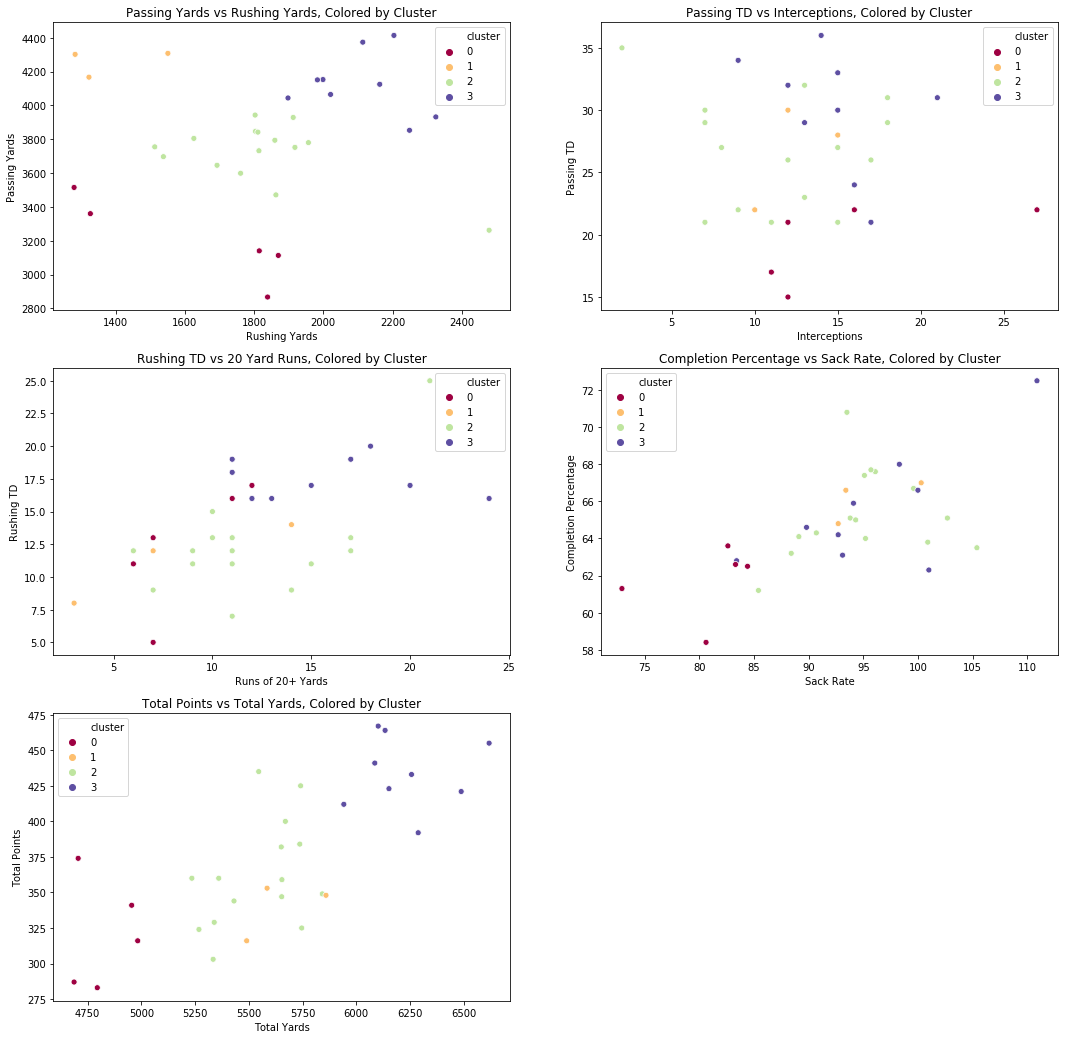

In [32]:
plt.figure(figsize=(18, 18)) #making a subplot

plt.subplot(3, 2, 1)
sns.scatterplot(y='Pass_Yds', x='Rush_Yds', hue='cluster', data=defenses_df, palette='Spectral')
plt.ylabel('Passing Yards')
plt.xlabel('Rushing Yards')
plt.title('Passing Yards vs Rushing Yards, Colored by Cluster')

plt.subplot(3, 2, 2)
sns.scatterplot(y='Pass_TD', x='Int', hue='cluster', data=defenses_df, palette='Spectral')
plt.ylabel('Passing TD')
plt.xlabel('Interceptions')
plt.title('Passing TD vs Interceptions, Colored by Cluster')

plt.subplot(3, 2, 3)
sns.scatterplot(y='Rush_TD', x='Run_20+', hue='cluster', data=defenses_df, palette='Spectral')
plt.ylabel('Rushing TD')
plt.xlabel('Runs of 20+ Yards')
plt.title('Rushing TD vs 20 Yard Runs, Colored by Cluster')

plt.subplot(3, 2, 4)
sns.scatterplot(y='Comp_Pct', x='Sck_Rate', hue='cluster', data=defenses_df, palette='Spectral')
plt.ylabel('Completion Percentage')
plt.xlabel('Sack Rate')
plt.title('Completion Percentage vs Sack Rate, Colored by Cluster')

plt.subplot(3, 2, 5)
sns.scatterplot(y='TotPts', x='TotYards', hue='cluster', data=defenses_df, palette='Spectral')
plt.ylabel('Total Points')
plt.xlabel('Total Yards')
plt.title('Total Points vs Total Yards, Colored by Cluster')
plt.show()

## K-Means Clustering- Normalized Data

In [33]:
norm_def = defenses_df.copy()

In [34]:
norm_def.head()

,Pass_Rk,Pts/G,TotPts,TotYards,Comp,Att,Comp_Pct,Att/G,Pass_Yds,Pass_Avg,...,Rush_Avg,Rush_Yds/G,Rush_TD,Run_Lng,Run_1st%,Run_20+,Run_40+,FUM,cluster,Team
0,4,26.6,425,5741.0,342,506,67.6,31.6,3262,7.1,...,4.9,154.9,25,65,27.3,21,4,3,2,Arizona Cardinals
1,27,26.4,423,6152.0,398,585,68.0,36.6,4153,7.5,...,4.9,124.9,16,92,28.1,13,1,10,3,Atlanta Falcons
2,5,17.9,287,4687.0,337,577,58.4,36.1,3360,6.3,...,3.7,82.9,11,35,23.2,6,0,2,0,Baltimore Ravens
3,1,23.4,374,4706.0,313,492,63.6,30.8,2867,6.3,...,4.2,114.9,17,43,25.2,12,1,10,0,Buffalo Bills
4,18,23.9,382,5651.0,353,529,66.7,33.1,3847,7.7,...,4.7,112.8,13,60,28.6,17,2,9,2,Carolina Panthers


In [35]:
norm_def = norm_def.drop('Team', 1)
norm_def = norm_def.drop('cluster', 1)

In [36]:
norm_def=((norm_def-norm_def.min())/(norm_def.max()-norm_def.min()))

In [37]:
norm_def.head()

,Pass_Rk,Pts/G,TotPts,TotYards,Comp,Att,Comp_Pct,Att/G,Pass_Yds,Pass_Avg,...,Run_Att/G,Rush_Yds,Rush_Avg,Rush_Yds/G,Rush_TD,Run_Lng,Run_1st%,Run_20+,Run_40+,FUM
0,0.096774,0.773913,0.771739,0.545831,0.364407,0.171053,0.652482,0.168421,0.255333,0.421053,...,1.000000,1.000000,0.882353,1.000000,1.00,0.521127,0.710280,0.857143,0.571429,0.1
1,0.838710,0.756522,0.760870,0.758674,0.838983,0.690789,0.680851,0.694737,0.831286,0.631579,...,0.432432,0.599666,0.882353,0.599466,0.55,0.901408,0.785047,0.476190,0.142857,0.8
2,0.129032,0.017391,0.021739,0.000000,0.322034,0.638158,0.000000,0.642105,0.318681,0.000000,...,0.117117,0.039199,0.176471,0.038718,0.30,0.098592,0.327103,0.142857,0.000000,0.0
3,0.000000,0.495652,0.494565,0.009839,0.118644,0.078947,0.368794,0.084211,0.000000,0.000000,...,0.603604,0.466222,0.470588,0.465955,0.60,0.211268,0.514019,0.428571,0.142857,0.8
4,0.548387,0.539130,0.538043,0.499223,0.457627,0.322368,0.588652,0.326316,0.633484,0.736842,...,0.288288,0.437031,0.764706,0.437917,0.40,0.450704,0.831776,0.666667,0.285714,0.7


In [38]:
km2 = KMeans(n_clusters=4, random_state=42).fit(norm_def)

km2_labels = km2.labels_

km2_cluster_centers = km2.cluster_centers_

In [39]:
norm_def['cluster'] = km2_labels
norm_def['Team'] = team_list

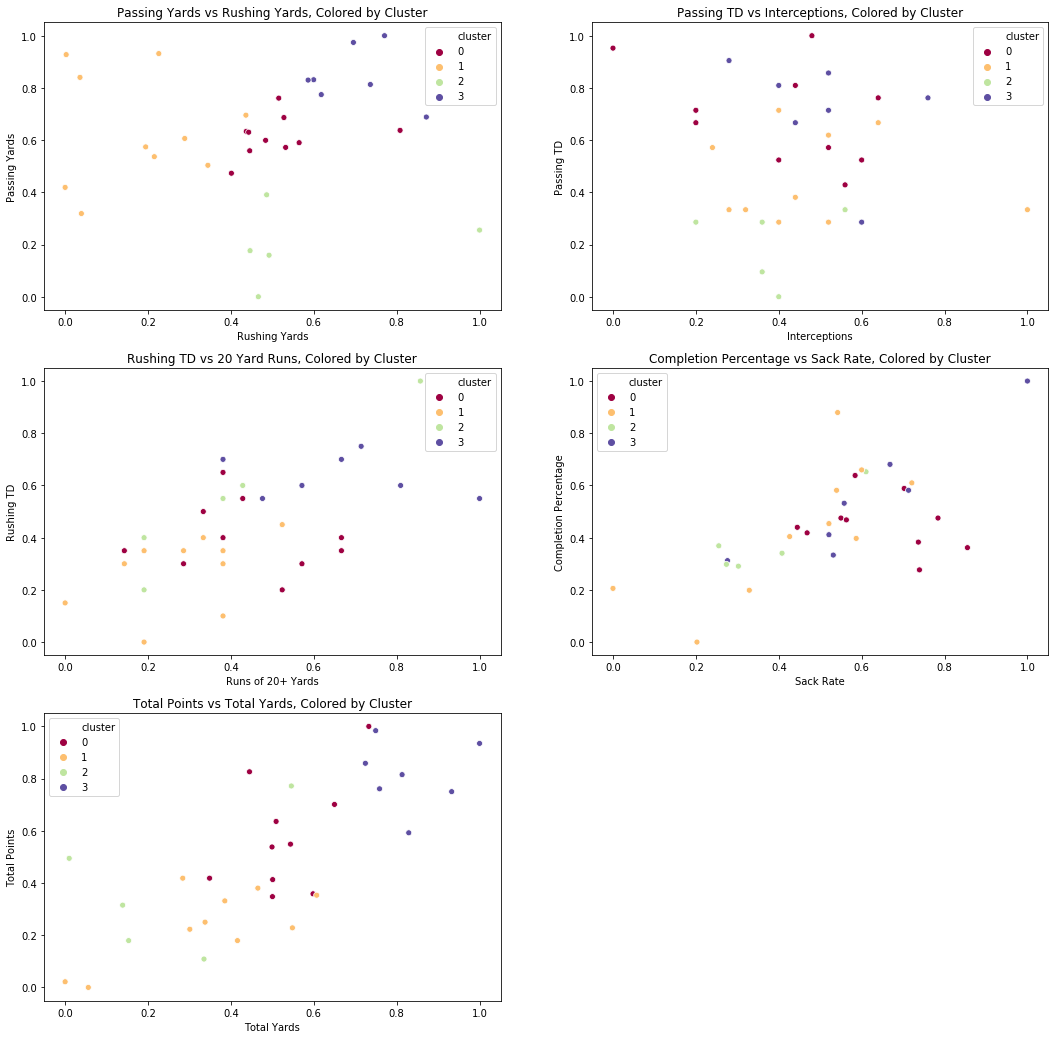

In [40]:
plt.figure(figsize=(18, 18)) #making a subplot

plt.subplot(3, 2, 1)
sns.scatterplot(y='Pass_Yds', x='Rush_Yds', hue='cluster', data=norm_def, palette='Spectral')
plt.ylabel('Passing Yards')
plt.xlabel('Rushing Yards')
plt.title('Passing Yards vs Rushing Yards, Colored by Cluster')

plt.subplot(3, 2, 2)
sns.scatterplot(y='Pass_TD', x='Int', hue='cluster', data=norm_def, palette='Spectral')
plt.ylabel('Passing TD')
plt.xlabel('Interceptions')
plt.title('Passing TD vs Interceptions, Colored by Cluster')

plt.subplot(3, 2, 3)
sns.scatterplot(y='Rush_TD', x='Run_20+', hue='cluster', data=norm_def, palette='Spectral')
plt.ylabel('Rushing TD')
plt.xlabel('Runs of 20+ Yards')
plt.title('Rushing TD vs 20 Yard Runs, Colored by Cluster')

plt.subplot(3, 2, 4)
sns.scatterplot(y='Comp_Pct', x='Sck_Rate', hue='cluster', data=norm_def, palette='Spectral')
plt.ylabel('Completion Percentage')
plt.xlabel('Sack Rate')
plt.title('Completion Percentage vs Sack Rate, Colored by Cluster')

plt.subplot(3, 2, 5)
sns.scatterplot(y='TotPts', x='TotYards', hue='cluster', data=norm_def, palette='Spectral')
plt.ylabel('Total Points')
plt.xlabel('Total Yards')
plt.title('Total Points vs Total Yards, Colored by Cluster')
plt.show()

In [41]:
norm_def.head(32)

,Pass_Rk,Pts/G,TotPts,TotYards,Comp,Att,Comp_Pct,Att/G,Pass_Yds,Pass_Avg,...,Rush_Avg,Rush_Yds/G,Rush_TD,Run_Lng,Run_1st%,Run_20+,Run_40+,FUM,cluster,Team
0,0.096774,0.773913,0.771739,0.545831,0.364407,0.171053,0.652482,0.168421,0.255333,0.421053,...,0.882353,1.000000,1.00,0.521127,0.710280,0.857143,0.571429,0.1,2,Arizona Cardinals
1,0.838710,0.756522,0.760870,0.758674,0.838983,0.690789,0.680851,0.694737,0.831286,0.631579,...,0.882353,0.599466,0.55,0.901408,0.785047,0.476190,0.142857,0.8,3,Atlanta Falcons
2,0.129032,0.017391,0.021739,0.000000,0.322034,0.638158,0.000000,0.642105,0.318681,0.000000,...,0.176471,0.038718,0.30,0.098592,0.327103,0.142857,0.000000,0.0,1,Baltimore Ravens
3,0.000000,0.495652,0.494565,0.009839,0.118644,0.078947,0.368794,0.084211,0.000000,0.000000,...,0.470588,0.465955,0.60,0.211268,0.514019,0.428571,0.142857,0.8,2,Buffalo Bills
4,0.548387,0.539130,0.538043,0.499223,0.457627,0.322368,0.588652,0.326316,0.633484,0.736842,...,0.764706,0.437917,0.40,0.450704,0.831776,0.666667,0.285714,0.7,0,Carolina Panthers
5,0.193548,0.000000,0.000000,0.055930,0.661017,0.888158,0.205674,0.884211,0.418875,0.000000,...,0.235294,0.000000,0.00,0.056338,0.009346,0.190476,0.000000,0.3,1,Chicago Bears
6,1.000000,0.930435,0.934783,1.000000,0.762712,0.684211,0.581560,0.684211,1.000000,0.842105,...,0.764706,0.771696,0.60,0.521127,0.663551,0.571429,0.285714,0.1,3,Cincinnati Bengals
7,0.774194,0.591304,0.592391,0.829104,0.796610,0.960526,0.312057,0.957895,0.813187,0.368421,...,0.764706,0.736983,0.75,0.338028,0.803738,0.714286,0.142857,0.4,3,Cleveland Browns
8,0.387097,0.217391,0.222826,0.300880,0.576271,0.407895,0.659574,0.410526,0.574014,0.578947,...,0.235294,0.194927,0.35,0.563380,0.242991,0.285714,0.142857,0.5,1,Dallas Cowboys
9,0.612903,0.356522,0.358696,0.598136,0.457627,0.453947,0.418440,0.452632,0.686490,0.736842,...,0.647059,0.528705,0.30,0.690141,0.009346,0.571429,0.714286,0.4,0,Denver Broncos


## Mean Shift Normalized Data

In [42]:
norm_def = norm_def.drop('cluster', 1)
norm_def = norm_def.drop('Team', 1)

In [43]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
my_bandwidth = estimate_bandwidth(norm_def)
my_bandwidth

1.5586399521308762

In [44]:
# Declare and fit the model.
ms = MeanShift(bandwidth=10000000, bin_seeding=True)
ms.fit(norm_def)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


## Initial Filtering and Data Cleaning

In [45]:
list(NE_df)

['play_id',
 'game_id',
 'home_team',
 'away_team',
 'posteam',
 'posteam_type',
 'defteam',
 'side_of_field',
 'yardline_100',
 'game_date',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'game_seconds_remaining',
 'game_half',
 'quarter_end',
 'drive',
 'sp',
 'qtr',
 'down',
 'goal_to_go',
 'time',
 'yrdln',
 'ydstogo',
 'ydsnet',
 'desc',
 'play_type',
 'yards_gained',
 'shotgun',
 'no_huddle',
 'qb_dropback',
 'qb_kneel',
 'qb_spike',
 'qb_scramble',
 'pass_length',
 'pass_location',
 'air_yards',
 'yards_after_catch',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'extra_point_result',
 'two_point_conv_result',
 'home_timeouts_remaining',
 'away_timeouts_remaining',
 'timeout',
 'timeout_team',
 'td_team',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'total_home_score',
 'total_away_score',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'no_sc

In [49]:
feat_list = ['play_id', 'game_id', 'posteam_type', 'defteam', 'yardline_100', 'game_seconds_remaining', 'down', 'goal_to_go', 'ydstogo', 'shotgun', 'no_huddle', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'posteam_score', 'defteam_score', 'full_play_type']

In [50]:
NE_df = NE_df.filter(items=feat_list)
NE_df.head()

,play_id,game_id,posteam_type,defteam,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,defteam_timeouts_remaining,posteam_score,defteam_score,full_play_type
135505,387,2012090904,away,TEN,74.0,3217.0,1,0.0,10,0,0,3.0,3.0,0.0,3.0,short_pass_right
135506,411,2012090904,away,TEN,66.0,3182.0,2,0.0,2,0,0,3.0,3.0,0.0,3.0,run_left
135507,432,2012090904,away,TEN,65.0,3163.0,3,0.0,1,0,1,3.0,3.0,0.0,3.0,run_left
135508,453,2012090904,away,TEN,48.0,3140.0,1,0.0,10,0,1,3.0,3.0,0.0,3.0,deep_pass_left
135509,475,2012090904,away,TEN,48.0,3133.0,2,0.0,10,0,0,3.0,3.0,0.0,3.0,run_middle


In [53]:
NE_df = pd.concat([NE_df, pd.get_dummies(NE_df['posteam_type'], drop_first=True)], axis=1)
NE_df = pd.concat([NE_df, pd.get_dummies(NE_df['defteam'], drop_first=True)], axis=1)

In [55]:
NE_df = NE_df.drop('posteam_type', 1)
NE_df = NE_df.drop('defteam', 1)

In [56]:
NE_df.head()

,play_id,game_id,yardline_100,game_seconds_remaining,down,goal_to_go,ydstogo,shotgun,no_huddle,posteam_timeouts_remaining,...,OAK,PHI,PIT,SD,SEA,SF,STL,TB,TEN,WAS
135505,387,2012090904,74.0,3217.0,1,0.0,10,0,0,3.0,...,0,0,0,0,0,0,0,0,1,0
135506,411,2012090904,66.0,3182.0,2,0.0,2,0,0,3.0,...,0,0,0,0,0,0,0,0,1,0
135507,432,2012090904,65.0,3163.0,3,0.0,1,0,1,3.0,...,0,0,0,0,0,0,0,0,1,0
135508,453,2012090904,48.0,3140.0,1,0.0,10,0,1,3.0,...,0,0,0,0,0,0,0,0,1,0
135509,475,2012090904,48.0,3133.0,2,0.0,10,0,0,3.0,...,0,0,0,0,0,0,0,0,1,0
